# Diagramas de Persistencia

Los diagramas de persistencia nos indican las propiedades topológicas (de nuestra base de datos) que persisten cuando hacemos variar el parámetro de filtración. En este caso, el parámetro de filtración es el radio de las bolas abiertas en nuestra cubierta (directamente relacionada con el complejo de Rips).

Decimos que una propiedad topológica nace cuando aparece por primera vez en el diagrama de persistencia y muere cuando desaparece. La duración de una propiedad topológica es el tiempo que vive en el diagrama de persistencia.

Mientras más alejada sea la muerte (o no exista muerte) de la nacimiento, la propiedad topológica es intrinseca a la base de datos.

Es importante mencionar que una propiedad topológica puede nacer y morir en el mismo instante de filtración, lo que significa que la propiedad topológica no es intrínseca a la base de datos. Pero una propiedad topológica no puede morir antes de nacer, por lo que parte inferior del rectangulo de la persistencia siempre es cero o no se toma en cuenta.

Veamos esto con algunos ejemplos:

Componentes conexas: https://gjkoplik.github.io/pers-hom-examples/0d_pers_2d_data_widget.html

Hoyo de dimensión 1: https://gjkoplik.github.io/pers-hom-examples/1d_pers_2d_data_widget.html 

# Intuición con Componentes Conexas

El número de componentes conexas persistentes indicará el número de grupos de datos que son intrínsecos a la base de datos. En el ejemplo siguiente, veremos que hay 3 componentes conexas persistentes, lo que significa que hay 3 grupos de datos que son intrínsecos a la base de datos.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import tadasets
import ripser
import persim
import gudhi as gd
import plotly.graph_objects as go

<function matplotlib.pyplot.show(close=None, block=None)>

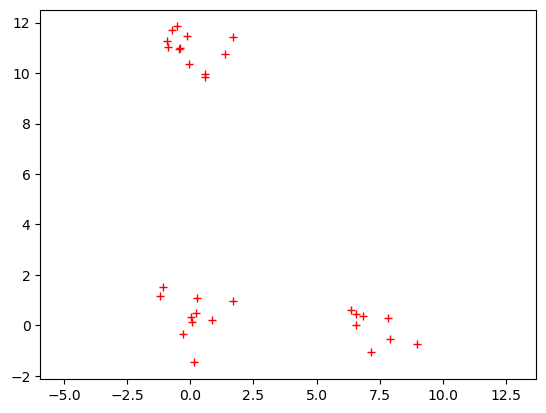

In [2]:
#Primero demos un conjunto de puntos simulados en 3 grupos
X1 = np.random.multivariate_normal([0,0],np.array([[1,0],[0,1]]),size = 10)
X2 = np.random.multivariate_normal([7,0],np.array([[1,0],[0,0.2]]),size = 8)
X3 = np.random.multivariate_normal([0,11],np.array([[1,0],[0,1]]),size = 12)
X = np.concatenate((X1,X2,X3))

plt.plot(X[:,0],X[:,1],'r+')
plt.axis('equal')
plt.show

### ¿Qué podemos decir de esta base de datos a primera vista?

1. ¿Cuántos grupos de datos (componentes conexas) intuyes que hay?
 Probablemente 3
2. ¿Cuénta con huecos? ¿De qué dimensión?
Sí, cuenta con huecos de dimensión 1.
3. Si existen huecos, ¿podemos decir si estos datos son recurrentes?
Probablemente sean recurrentes.




In [3]:
# Vamos a aumentar la dimensión de este array para utilizar la función rips_graph.
Xaug=np.array([[X[i,0],X[i,1],0] for i in range(len(X))])

In [4]:

def rips_graph(points,mel):
    """
    Generate the Vietoris-Rips complex on the given set of points in 3D.
    Only simplexes up to dimension 2 (2-skeleton) are computed.
    The mel parameter denotes the distance cut-off value.
    """
    rc = gd.RipsComplex(points=points,max_edge_length=mel)
    st = rc.create_simplex_tree(max_dimension=3)
    triangles = np.array([s[0] for s in st.get_skeleton(2) if len(s[0])==3])
    edges = []
    for s in st.get_skeleton(1):
        e = s[0]
        if len(e) == 2:
            edges.append(points[[e[0],e[1]]])
            
    f2 = go.Mesh3d(
        x=points[:,0],
        y=points[:,1],
        z=points[:,2],
        i = triangles[:,0],
        j = triangles[:,1],
        k = triangles[:,2],
    )
    f0 = go.Scatter3d(x=points[:,0], y=points[:,1],z=points[:,2], mode="markers")
    data = [f2, f0]
# Plot edges
    for pts in edges:
        seg = go.Scatter3d(x=pts[:,0],y=pts[:,1],z=pts[:,2],mode="lines",line=dict(color='green'))
        data.append(seg)
    fig = go.Figure(data=data,layout=dict(showlegend=False))
    fig.show()

### Ejemplo:

Realiza el plot del complejo de Rips del conjunto de datos $X,$ utilizando diferentes radios: 
1. $r=1.$
2. $r=2.$
3. $r=10.$

Dependiendo de los radios, ¿qué observas? ¿Qué puedes decir de la base de datos (propiedades topológicas)?

A medida que vamos aumentando los radios, observamos que algunas propiedades no se conservan a medida que el radio aumenta. De hecho, al final se genera una sola componente conexa.

In [5]:
rips_graph(Xaug, 1)
rips_graph(Xaug, 2)
rips_graph(Xaug, 10)

## Vamos a hacer el análisis de Persistencia

Vamos a comparar lo observado anteriormente con el diagrama de persistencia. Para esto, vamos a utilizar la librería "gudhi" de Python.

Vamos  utilizar otro método para construir nuestro complejo de Rips utilizando una matriz de distancia que encapsula la información de las distancias para dos puntos diferentes en nuestra nube de puntos.

In [6]:
from scipy.spatial import distance_matrix
DX=distance_matrix(X,X,2)

Ahora construimos nuestro arbol de complejos de Rips utilizando la matriz de distancias y max_edge_lenght nos indica que tan grande será el radio de las bolas abiertas.

In [7]:
skeletonX=gd.RipsComplex(
    distance_matrix = DX, 
    max_edge_length = 2
) 

# Aquí vamos a pedir que nuestra complejo sea máximo de dimensión 1 (o sea, sólo tenga vértices y aristas)
Rips_simplex_tree_X = skeletonX.create_simplex_tree(max_dimension = 1)

Vamos a calcular la persistencia de las propiedades topológicas ($\beta_0$ y $\beta_1$) de nuestros complejos de Rips en el árbol (filtración).

Veamos los primeros 10 filas, ¿Qué observas?

In [8]:
Barcodes_Rips_X = Rips_simplex_tree_X.persistence()
Barcodes_Rips_X[0:20]

[(0, (0.0, inf)),
 (0, (0.0, inf)),
 (0, (0.0, inf)),
 (0, (0.0, 1.4297082205483058)),
 (0, (0.0, 1.2297714614086672)),
 (0, (0.0, 1.1258875122085543)),
 (0, (0.0, 1.123131170181634)),
 (0, (0.0, 1.0641036648000246)),
 (0, (0.0, 1.0046388304899314)),
 (0, (0.0, 0.929248795280347)),
 (0, (0.0, 0.8418588906271778)),
 (0, (0.0, 0.7562070625119504)),
 (0, (0.0, 0.7326749059773465)),
 (0, (0.0, 0.7282936786940756)),
 (0, (0.0, 0.6727144051867582)),
 (0, (0.0, 0.5986760145854335)),
 (0, (0.0, 0.5925600112090035)),
 (0, (0.0, 0.5526466255891873)),
 (0, (0.0, 0.46862838539696783)),
 (0, (0.0, 0.4334724915710765))]

In [9]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True

usetex mode requires TeX.


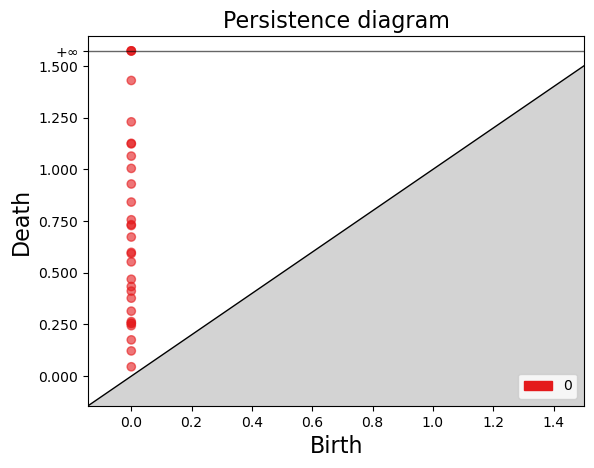

In [10]:
gd.plot_persistence_diagram(Barcodes_Rips_X);

Notemos que en nuestro gráfico de persistencia, hay tres puntitos rojos que duraron mucho más tiempo en comparación que los otros. Esto nos indica que hay tres componentes conexas persistentes en nuestra base de datos.

Por lo tanto, si quisieramos hacer un clustering de nuestros datos, podríamos hacerlo en tres grupos y con esto garantizar que los datos en cada cluster van a estar intrínsecamente relacionados.

## Otra paquetería para lo mismo

Ahora utilizaremos ripser.ripser que es una paquetería de C++ que nos permite calcular la persistencia de las propiedades topológicas de nuestros complejos de Rips de manera eficiente (con algoritmos especializados).

La diferencia entre el método de gudhi y ripser es que el método de gudhi calcula la persistencia de las propiedades topológicas de una filtración comenzando desde un valor dado (un radio $r$ inicial para construir la filtración) y en ripser no es necesario inicializar esto.

In [11]:
def diagram_sizes(dgms):
    return ", ".join([f"|$H_{i}$|={len(d)}" for i, d in enumerate(dgms)])   #Aquí almacenamos la cantidad de generadores de cada espacio de homología. Estas cantidades se muestran en la impresión del mismo (puedes omitirlo si gustas, por supuesto haciendo los cambios necesarios en el código del diagrama)

Vamos a construir el gráfico de persistencia para el mismo conjunto de datos con ripser suponiendo que nuestro complejo simplicial es de dimensión 2, y veamos si es necesaria esta suposición o no.

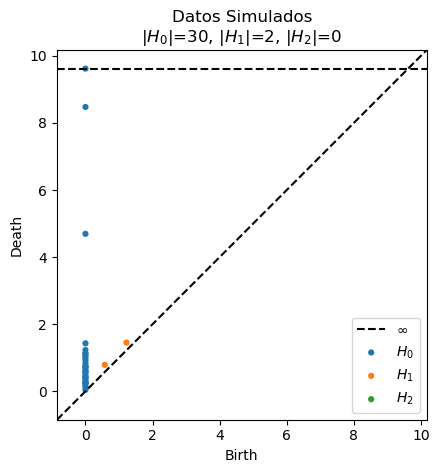

In [12]:
dgm_X = ripser.ripser(X,maxdim=2)['dgms'] #Aquí se construye y grafica el diagrama de persistencia (en este caso, de los puntos simulados). maxdim es la dimensión máxima en homología que quieres que se muestre.
persim.plot_diagrams(
    dgm_X, 
    show=True, 
    title=f"Datos Simulados\n{diagram_sizes(dgm_X)}"
) 

#### ¿Fue necesaria nuestra suposición de que nuestro complejo de Rips era de dimensión 2?

No, ya que se observa que se evalúan diversas dimensiones y el diagrama nos revela estas dimensiones.

# Analicemos un circulo topológico

Veamos como se ve un conjunto de datos circular topológico.

In [13]:
import math
from random import random
def generate_circle(dim,n, radius, max_noise):
    """
    Generate n points on a 1-sphere with the center in the point (0,0) 
    with the given radius. 
    
    Noise is added so that the distance from
    the generated point to some point on the sphere does not
    exceed max_noise parameter.
    
    Returns the list of generated points.    
    """
    points = []
    if dim==3:
        for i in range(n):
            anglet = 2 * math.pi * random()
            anglep = 2* math.pi *random()
            noise = max_noise * random()
            r = radius * (1 + noise)
            point = [r * math.cos(anglet)*math.cos(anglep), r * math.sin(anglet)*math.cos(anglep),r*math.sin(anglep)]
            points.append(point)
    if dim==2:
        for i in range(n):
            anglet = 2 * math.pi * random()
            noise = max_noise * random()
            r = radius * (1 + noise)
            point = [r * math.cos(anglet), r * math.sin(anglet),0]
            points.append(point)
    return np.array(points)

In [14]:
circle = generate_circle(2,100, 10, 1)
fig = go.Figure(data=[go.Scatter3d(x=circle[:,0], y=circle[:,1],z=circle[:,2],
                                   mode='markers')])
fig.show()

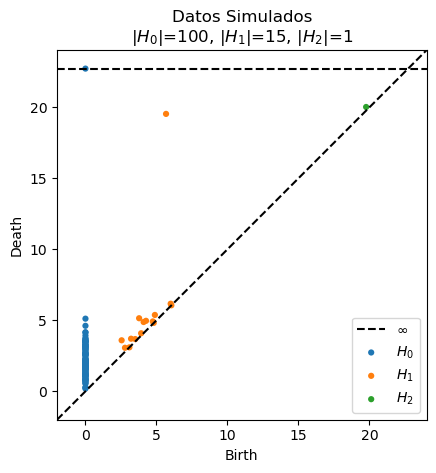

In [15]:
dgm_X = ripser.ripser(circle,maxdim=2)['dgms'] #Aquí se construye y grafica el diagrama de persistencia (en este caso, de los puntos simulados). maxdim es la dimensión máxima en homología que quieres que se muestre.
persim.plot_diagrams(
    dgm_X, 
    show=True, 
    title=f"Datos Simulados\n{diagram_sizes(dgm_X)}"
) 

In [16]:
aux=np.array([[25,0,0]+circle[i] for i in range(len(circle))])
doublecircle=np.append(circle,aux,0)
fig = go.Figure(data=[go.Scatter3d(x=doublecircle[:,0], y=doublecircle[:,1],z=doublecircle[:,2],
                                   mode='markers')])
fig.show()

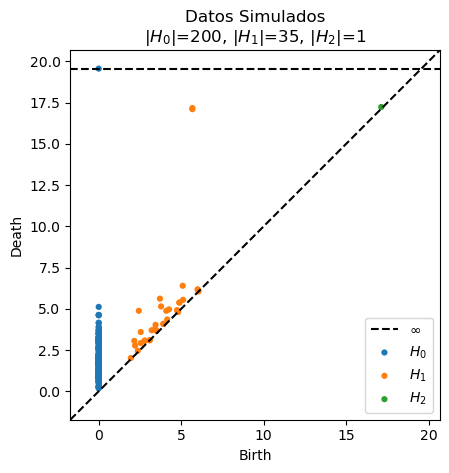

In [17]:
dgm_X = ripser.ripser(doublecircle,maxdim=2)['dgms'] #Aquí se construye y grafica el diagrama de persistencia (en este caso, de los puntos simulados). maxdim es la dimensión máxima en homología que quieres que se muestre.
persim.plot_diagrams(
    dgm_X, 
    show=True, 
    title=f"Datos Simulados\n{diagram_sizes(dgm_X)}"
) 

### Ejercicio

Haz un análisis de persistencia para el conjunto de datos "calificaciones.csv" que contiene la información de las calificaciones de 3 parciales en una materia de 10000 alumnos.

Responden las siguientes preguntas:

1. ¿Qué propiedades topológicas persisten?
2. ¿Qué podemos inferir de estas propiedades topológicas relativas a la base de datos?

Persisten únicamente las componentes conexas. Las cuales son 3, por lo que podemos inferir 3 grupos bien definidios de alumnos  o calificaciones.

In [18]:
import pandas as pd

In [21]:
# Upload the data
data = pd.read_csv("calificaciones.csv")

# Select just neccesary columns
selected_columns = data.iloc[:100, [1,2,3]]

#Convert to an array
X = selected_columns.to_numpy()


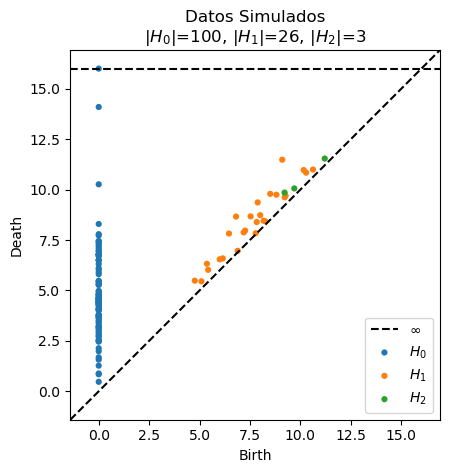

In [22]:
dgm_X = ripser.ripser(X,maxdim=2)['dgms'] #Aquí se construye y grafica el diagrama de persistencia (en este caso, de los puntos simulados). maxdim es la dimensión máxima en homología que quieres que se muestre.
persim.plot_diagrams(
    dgm_X, 
    show=True, 
    title=f"Datos Simulados\n{diagram_sizes(dgm_X)}"
) 